# Cavity quality factor, effective mode volume, and Purcell factor

In this notebook, we will walk through the process of calculating the quality factor ($Q$), the effective mode volume ($V_{eff}$), and the Purcell factor ($F_{p}$) of a L3 photonic crystal (PhC) nanocavity. We start by using the [Resonance Finder](../_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html#tidy3d.plugins.resonance.ResonanceFinder.html) plugin to find the L3 PhC cavity fundamental resonance and extract its information. For those not familiar with the `Resonance Finder`, detailed information is available in [Extracting resonance information using Resonance Finder](https://www.flexcompute.com/tidy3d/examples/notebooks/ResonanceFinder/), [Optimized photonic crystal L3 cavity](https://www.flexcompute.com/tidy3d/examples/notebooks/OptimizedL3/), or [Band structure calculation of a photonic crystal slab](https://www.flexcompute.com/tidy3d/examples/notebooks/Bandstructure/) notebooks. Then, we show how to estimate the cavity effective mode volume from the frequency-domain fields. Lastly, the Purcell factor is calculated from the quality factor and the mode effective volume.

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/tidy3d/learning-center/fdtd101/) tutorials. 

## References
`[1] Peter Lodahl, Sahand Mahmoodian, and Søren Stobbe, "Interfacing single photons and single quantum dots with photonic nanostructures," Rev. Mod. Phys. 87, 347 (2015)` [DOI: 10.1103/RevModPhys.87.347](<https://doi.org/10.1103/RevModPhys.87.347>)

`[2] R. Coccioli, M. Boroditsky, K.W. Kim, Y. Rahmat-Samii, and E. Yablonovitch, "Smallest possible electromagnetic mode volume in a dielectric cavity,"  IEE Proceedings - Optoelectronics 145(6), 391 – 397 (1998)` [DOI: 10.1049/ip-opt:19982468](<https://doi.org/10.1049/ip-opt:19982468>)

`[3] P. T. Kristensen, C. Van Vlack, and S. Hughes, "Generalized effective mode volume for leaky optical cavities," Opt. Lett. 37, 1649-1651 (2012)` [DOI: 10.1364/OL.37.001649](<https://doi.org/10.1364/OL.37.001649>)

`[4] Y. Xu, J. S. Vučković, R. K. Lee, O. J. Painter, A. Scherer, and A. Yariv, "Finite-difference time-domain calculation of spontaneous emission lifetime in a microcavity," J. Opt. Soc. Am. B 16, 465-474 (1999)` [DOI: 10.1364/JOSAB.16.000465](<https://doi.org/10.1364/JOSAB.16.000465>)

In [1]:
# Standard python imports.
import numpy as np
import matplotlib.pyplot as plt

# Tidy3D imports.
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.resonance import ResonanceFinder

## PhC L3 Cavity Set Up
To illustrate the calculation of cavity quality factor, effective mode volume, and Purcell factor, we will build an L3 PhC nanocavity. The cavity parameters were obtained from Fig. 23 of `[1]`.

In [2]:
# PhC nanocavity geometry.
a = 0.240
r = 0.3 * a
t = 0.6 * a
r_1 = 0.24 * a
d_1 = 0.16 * a
n_x = 21
n_y = 17

# PhC nanocavity material.
n = 3.46
mat_slab = td.Medium(permittivity=n**2)
mat_hole = td.Medium(permittivity=1)

# Simulation wavelength.
wl_min = 0.90
wl_max = 0.92
n_wl = 21
wl_c = (wl_min + wl_max) / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq_c = td.C_0 / wl_c
freq_range = td.C_0 / wl_range
freq_bw = 0.5 * (freq_range[0] - freq_range[-1])

# Simulation runtime.
runtime_fwidth = 20.0  # In units of 1/frequency bandwidth of the source.
t_start_fwidth = 2.0  # Time to start monitoring after source has decayed, units of 1/frequency bandwidth.
run_time = runtime_fwidth / freq_bw
t_start = t_start_fwidth / freq_bw
print(f"Total runtime = {(run_time*1e12):.2f} ps")
print(f"Start monitoring fields after {(t_start*1e12):.2f} ps")

Total runtime = 5.52 ps
Start monitoring fields after 0.55 ps


The following function was adapted from the notebook [Defining common photonic crystal structures](https://www.flexcompute.com/tidy3d/examples/notebooks/PhotonicCrystalsComponents.html) and is employed to create the L3 PhC nanocavity holes.

In [3]:
def hex_l_cavity(
    R: float = 0.26,
    side_R: float = 0.1,
    del_R: float = 0.0,
    spacing_x: float = 0,
    spacing_y: float = 0,
    n_x: int = 34,
    n_y: int = 17,
    height: float = 0.22,
    mat_hole: td.Medium = td.Medium(permittivity=1),
) -> td.Structure:
    # parameters
    # ------------------------------------------------------------
    # R: radius of the cylinders (um)
    # side_R: radii of the two ends of the L-cavity (um)
    # del_R: shift of the two ends of the L-cavity (um)
    # spacing_x: distance between centers of cylinders in x direction (um)
    # spacing_y: distance between centers of cylinders in y direction (um)
    # n_x: number of cylinders in x direction
    # n_y: number of cylinders in y direction
    # height: height of cylinders
    # mat_hole: medium of the PhC cylinders

    x0 = 0  # x coordinate of center of the array (um).
    y0 = 0  # y coordinate of center of the array (um).
    z0 = 0  # z coordinate of center of the array (um).
    l_number = 3  # Number of cylinders removed from center (along x direction).
    reference_plane = "bottom"  # Reference plane.
    sidewall_angle = 0  # Angle slant of cylinders.
    axis = 2  # Cylinders axis.

    cylinders = []
    if n_y % 2 == 0:
        n_y -= 1  # only odd numbers for n_y work for symmetry

    n_middle = n_x - n_x % 2 + l_number % 2

    for i in range(-(n_y // 2), n_y // 2 + 1):  # go up columns
        n_row = (
            n_middle + (i % 2) * (-1) ** l_number
        )  # calculates number of cylinders in current row
        for j in range(-n_row + 1, n_row + 1, 2):  # go along rows
            if i != 0 or abs(j) > l_number:  # don't populate cavity with cylinders
                var_radius = R
                shift_x = 0
                if i == 0 and (
                    abs(j) == l_number + 1
                ):  # checks if cylinder is on side of cavity
                    var_radius = side_R
                    shift_x = del_R * np.sign(j)
                c = td.Cylinder(
                    axis=axis,
                    sidewall_angle=sidewall_angle,
                    reference_plane=reference_plane,
                    radius=var_radius,
                    center=(x0 + j * spacing_x + shift_x, y0 + i * spacing_y, z0),
                    length=height,
                )
                cylinders.append(c)
    structure = td.Structure(
        geometry=td.GeometryGroup(geometries=cylinders), medium=mat_hole
    )
    return structure

Next, we will define the PhC structure. We consider a hexagonal lattice to calculate the periodicity in `x`- and `y`-directions.

In [4]:
# PhC periodicity
p_x = a * np.cos(60 * np.pi / 180)
p_y = a * np.sin(60 * np.pi / 180)

# Simulation size.
pml_gap = 0.6 * wl_max
size_x = 2 * n_x * p_x
size_y = n_y * p_y
size_z = t + 2 * pml_gap
_inf = 10

# PhC slab.
phc_slab = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-_inf - size_x / 2, -_inf - size_y / 2, -t / 2),
        rmax=(+_inf + size_x / 2, +_inf + size_y / 2, +t / 2),
    ),
    medium=mat_slab,
)

# PhC holes.
phc_holes = hex_l_cavity(
    R=r,
    side_R=r_1,
    del_R=d_1,
    spacing_x=p_x,
    spacing_y=p_y,
    n_x=n_x,
    n_y=n_y,
    height=t,
    mat_hole=mat_hole,
)

We will include a point dipole at the center of the simulation domain to excite only the fundamental L3 PhC nanocavity mode. The [Resonance Finder](../_autosummary/tidy3d.plugins.resonance.ResonanceFinder.html#tidy3d.plugins.resonance.ResonanceFinder.html) plugin needs at least one `FieldTimeMonitor` to record the field as a function of time. Importantly, we start the monitors after the source pulse has decayed.

In [5]:
# Point dipole source.
pulse = td.GaussianPulse(freq0=freq_c, fwidth=freq_bw)
dip_source = td.PointDipole(
    source_time=pulse,
    center=(0, 0, 0),
    polarization="Ey",
    name="dip_source",
)

# Field time monitor.
mon_fieldtime = td.FieldTimeMonitor(
    fields=["Ey"],
    center=(0, 0, 0),
    size=(0, 0, 0),
    start=t_start,
    name="monitor_time",
)

17:05:28 -03 WARNING: Default value for the field monitor 'colocate' setting has
             changed to 'True' in Tidy3D 2.4.0. All field components will be    
             colocated to the grid boundaries. Set to 'False' to get the raw    
             fields on the Yee grid instead.                                    

In the simulation, we will include a 3D `FieldMonitor` to calculate the cavity effective mode volume. We have obtained the resonance frequency from a previous simulation.

In [6]:
# Mode resonance frequency.
mode_freq = 3.291688e14

# Apodization to exclude the source pulse from the frequency-domain monitors.
apod = td.ApodizationSpec(start=t_start, width=run_time - t_start)

# Field monitor.
mon_box = td.Box(center=(0, 0, 0), size=(size_x / 2, size_y / 2, 4 * t))
mon_field = td.FieldMonitor(
    center=mon_box.center,
    size=mon_box.size,
    freqs=mode_freq,
    name="field_vol",
    colocate=False,
    apodization=apod,
)

Now, we can build and run the simulation. It is worth mentioning that we set `shutoff=0` to run the simulation only for the `run_time` period. Otherwise, the simulation can take a very long time for the fields to decay fully.

In [7]:
sim = td.Simulation(
    center=(0, 0, 0),
    size=(size_x, size_y, size_z),
    grid_spec=td.GridSpec.auto(wavelength=wl_c, min_steps_per_wvl=20),
    structures=[phc_slab, phc_holes],
    sources=[dip_source],
    monitors=[mon_fieldtime, mon_field],
    run_time=run_time,
    shutoff=0,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    normalize_index=None,
    symmetry=(1, -1, 1),
)

sim.plot_3d(width=400, height=400)

             WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 3 WARNING messages.                            

Before running the simulation, let's look at the source and monitor positions to certify we are measuring the fields after the sources have fully decayed.

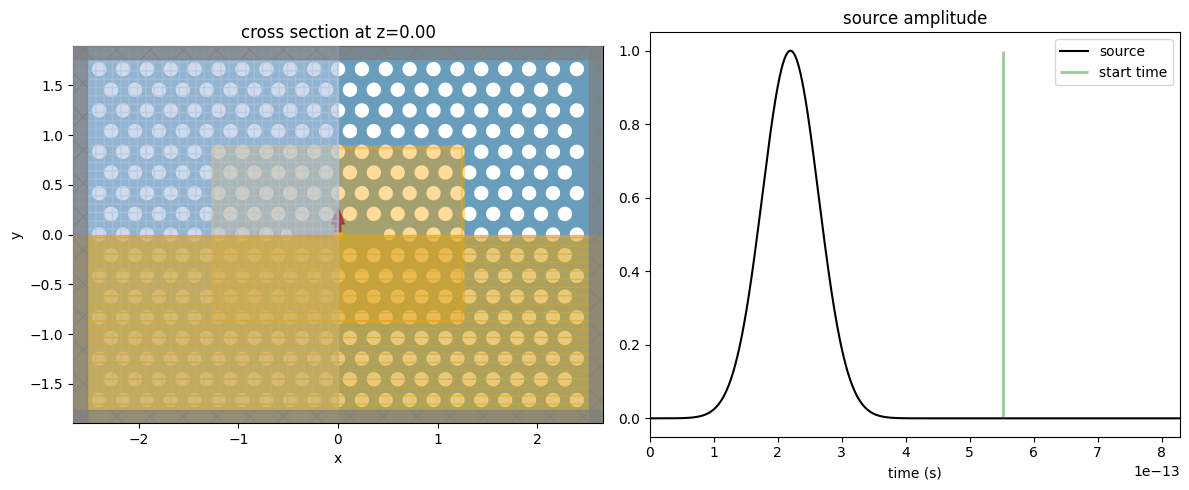

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
sim.plot(z=0.0, ax=ax1)

plot_time = 3 / freq_bw
sim.sources[0].source_time.plot(
    times=np.linspace(0, plot_time, 1001), val="abs", ax=ax2
)
ax2.set_xlim(0, plot_time)
ax2.vlines(t_start, 0, 1, linewidth=2, color="g", alpha=0.4)
ax2.legend(["source", "start time"])
plt.show()

Now, let's run the simulation!

In [9]:
job = web.Job(simulation=sim, task_name="l3_nanocavity", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")

17:05:29 -03 Created task 'l3_nanocavity' with task_id                          
             'fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=588647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=190821;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\taskId]8;;\]8;id=588647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\=]8;;\]8;id=263885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\fdve]8;;\]8;id=588647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\-0ce14be0-341]8;;\
             ]8;id=588647;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\0-42f6-8a6c-873a37c9737fv1']8;;\.

Output()

17:05:37 -03 status = queued

Output()

17:05:41 -03 status = preprocess

17:05:48 -03 Maximum FlexCredit cost: 0.084. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:07:23 -03 status = postprocess

Output()

17:07:35 -03 status = success

17:07:36 -03 View simulation result at                                          
             ]8;id=425537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=935580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\taskId]8;;\]8;id=425537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\=]8;;\]8;id=31585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\fdve]8;;\]8;id=425537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\-0ce14be0-341]8;;\
             ]8;id=425537;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ce14be0-3410-42f6-8a6c-873a37c9737fv1\0-42f6-8a6c-873a37c9737fv1']8;;\.

Output()

17:07:40 -03 loading simulation from data/simulation_data.hdf5

             WARNING: Structure at structures[1] was detected as being less than
             half of a central wavelength from a PML on side x-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

             WARNING: Suppressed 3 WARNING messages.                            

## Cavity Field Distribution
After running the simulation, we can obtain the frequency-domain fields to see what the cavity mode looks like. It is worth mentioning that frequency-domain results are considered accurate only if we run the simulation until the time-domain fields completely decays within the monitor region.

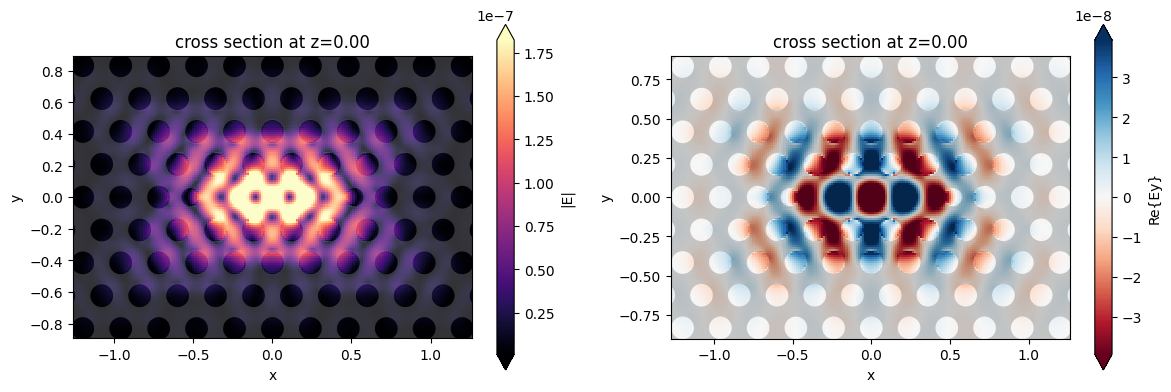

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(12, 4))

sim_data.plot_field("field_vol", "E", "abs", z=0, ax=ax1)
sim_data.plot_field("field_vol", "Ey", "real", z=0, ax=ax2)
plt.show()

## Quality Factor
Now, we can analyze the simulation data and calculate the resonance information from the time domain fields. The `run()` method returns an `xr.Dataset` containing the decay rate, Q-factor, amplitude, phase, and estimation error.


In [11]:
resonance_finder = ResonanceFinder(freq_window=(freq_range[-1], freq_range[0]))
resonance_data = resonance_finder.run(signals=sim_data["monitor_time"])
resonance_data.to_dataframe()

,decay,Q,amplitude,phase,error
freq,,,,,
3.291688e+14,1.084839e+10,95324.228568,143236.795885,-0.886197,0.01196


Within the wavelength range from 900 to 920 nm, the L3 nanocavity has only the fundamental resonance, which shows a Q-factor of 
$9.53\times10^{4}$, very close to the value of $9.60\times10^{4}$ reported in `[1]`.

## Cavity Effective Mode Volume

The cavity effective mode volume ($V_{eff}$) describes how efficiently the cavity concentrates the electromagnetic field in a restricted space. The $V_{eff}$ value can be calculated from the cavity mode field distribution as defined by `[2]`:

$V_{eff} = \frac{\int\varepsilon(r)|E(r)|^{2}d^{3}r}{max[\varepsilon(r)|E(r)|^{2}(r)]}$,

where $\varepsilon(r)$ is the cavity permittivity distribution, which can be obtained from the simulation object. This expression for $V_{eff}$ is not strictly valid for the case of open leaky cavities supporting quasimodes `[3]`.

Below, we estimate $V_{eff}$ in units of $\mu m^{3}$, $m^{3}$, and in units of $(\lambda/n)^{3}$ which is also commonly used. The volume integral is performed using [xarray.Dataset.integrate](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.integrate.html), which conveniently integrates the integrand along the given coordinates using the trapezoidal rule. 


In [12]:
# Permittivity distribution.
grid = sim.discretize(box=mon_box, extend=False)
eps = np.real(sim.epsilon_on_grid(grid=grid, coord_key="centers").values)

# Electric field obtained at the grid coordinates.
e_field = sim_data["field_vol"].at_coords(
    td.Coords(x=grid.centers.x, y=grid.centers.y, z=grid.centers.z)
)
e_x = e_field.isel(f=0).Ex
e_y = e_field.isel(f=0).Ey
e_z = e_field.isel(f=0).Ez
e_2 = np.abs(e_x) ** 2 + np.abs(e_y) ** 2 + np.abs(e_z) ** 2

# Calculation of effective mode volume.
e_eps = eps * e_2
num = e_eps.integrate(coord=("x", "y", "z")).item()
den = np.amax(e_eps)
V_eff = (num / den).values

print(f"V_eff = {V_eff:.3f} um^3")
print(f"V_eff = {V_eff / 1e18:.3e} m^3")
print(f"V_eff = {V_eff / (wl_c/n)**3:.2f} (lambda/n)^3")

V_eff = 0.015 um^3
V_eff = 1.467e-20 m^3
V_eff = 0.81 (lambda/n)^3


The result is close to the value of $0.75 (\lambda/n)^{3}$ reported in `[1]`. We can further improve the $V_{eff}$ accuracy by reducing the source bandwidth, running the simulation longer, and choosing a finer grid mesh.

## Purcell Factor

As stated in `[1]`, nanophotonic cavities enable the pronounced enhancement of a single optical mode due to a substantial spatial and spectral confinement of light so that the radiative decay rate into the cavity mode $\gamma_{cav}$ is much faster than the decay rate into all other (nonguided) modes $\gamma_{ng}$. As usually $\gamma_{cav} \gg \gamma_{ng}$, we can describe the Purcell factor as the ratio between the radiative decay rate of a dipole-like emitter into a photonic structure to the radiative rate of an identical emitter placed in a homogeneous medium of refractive index $n$, i. e., $F_{p} = \gamma_{cav}/\gamma_{hom}$. The Purcell factor measures the enhancement in spontaneous emission rate, and it is essential for many applications, e.g., LEDs, lasers, and single-photon sources.

When dealing with low-quality factor resonances, we can calculate the Purcell factor by the ratio of the radiation power for a dipole in a cavity ($P_{cav}$) and the dipole emission power in a homogeneous dielectric material  ($P_{hom}$), i. e.,  $F_{p} = P_{cav}/P_{hom}$, as defined in `[4]`. An example of such an approach is included in this [notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/BullseyeCavityPSO/).

However, when long-lived resonances are present in the FDTD simulation (this case), calculating the dipole power emission is not so practical, as we might wait for a long time until the fields decay to negligible values within the simulation domain. So, we can derive the Purcell factor as `[1]`:

$F_{p}(r, \omega, e_{d}) = F_{p}^{max} f(r) |e_{d} \cdot e_{c}|^{2}\frac{\omega_{c}^{2}/4Q^{2}}{(\omega_{c} - \omega)^{2} + \omega_{c}^{2}/4Q^{2}}$,

where $F_{p}^{max}$ is the maximum achievable Purcell factor, $f(r)$ defines the spatial mismatch between the emitter position and the maximum cavity field amplitude, $|e_{d} \cdot e_{c}|^{2}$ accounts for the alignment between the emitter and cavity fields, and the last term corrects for a detuning concerning the cavity resonance.

When optimizing photonic cavity structures, we can usually consider an emitter in resonance and optimally placed and oriented concerning the cavity fields so that,

$F_{p} = F_{p}^{max} = \frac{3}{4\pi^{2}}\left(\frac{\lambda}{n}\right)^{3}\frac{Q}{V_{eff}}$.

This way, we can derive the Purcell value from the cavity quality factor and effective mode volume, as below:

In [13]:
Q = resonance_data["Q"][0].values
mode_freq = resonance_data["freq"][0].values

F_p = (3 / (4 * np.pi**2)) * ((wl_c / n) ** 3) * (Q / V_eff)
print(f"F_p = {F_p:.0f}")

F_p = 8985


Lastly, let's see how the Purcell factor would vary under a $\pm 50$ GHz detuning.

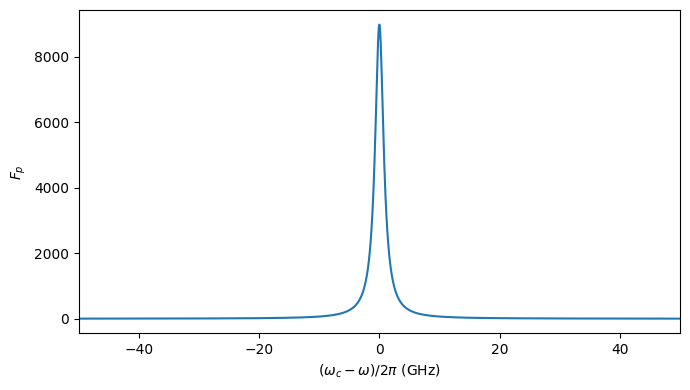

In [14]:
w_c = 2 * np.pi * mode_freq
detuning = 50e9
del_w = np.linspace(-detuning * 2 * np.pi, detuning * 2 * np.pi, 2000)
F_p_w = F_p * (w_c**2 / (4 * Q) ** 2) / (del_w**2 + (w_c**2 / (4 * Q) ** 2))

fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(7, 4))

ax1.plot(del_w * 1e-9 / (2 * np.pi), F_p_w)
ax1.set_xlabel("$(\omega_{c} - \omega)/2 \pi$ (GHz)")
ax1.set_ylabel("$F_{p}$")
ax1.set_xlim(-detuning * 1e-9, detuning * 1e-9)
plt.show()